In [1]:
#import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
import sqlite3
from sqlite3 import Error
plt.style.use('fivethirtyeight')

database = "market_data.db"

In [2]:
# Function to create a connection to the SQLite database
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

In [3]:
# Define the Bitcoin ticker symbol and the date range
ticker = "BTC-USD"
start_date = "2020-01-01"

# Fetch historical data
####bitcoin_data = yf.download(ticker, start=start_date)

# Create a connection to the SQLite database
conn = create_connection(database)

# Check if the connection is successful
if conn is not None:
    # Read the data from the SQLite database into a Pandas DataFrame
    crypto_data = pd.read_sql_query("SELECT * FROM Crypto_Data", conn)

    # Close the connection to the SQLite database
    conn.close()
else:
    print("Error! Cannot create the database connection.")

# Dataframe preview
print(crypto_data.head())

                  Date             Coin         Price        Volume  \
0  2020-09-17 00:00:00    Binance - BNB     27.855081  7.117046e+08   
1  2020-09-17 00:00:00    Bitcoin - BTC  10952.249969  2.445909e+10   
2  2020-09-17 00:00:00    Cardano - ADA      0.091295  6.814108e+08   
3  2020-09-17 00:00:00  Dogecoin - DOGE      0.002820  1.553926e+08   
4  2020-09-17 00:00:00   Ethereum - ETH    365.130551  1.329820e+10   

     Market_Cap  
0  4.122358e+09  
1  2.025240e+11  
2  2.842676e+09  
3  3.560026e+08  
4  4.113618e+10  


In [4]:
bitcoin_data_df = crypto_data.loc[crypto_data['Coin'] == 'Bitcoin - BTC'].copy()
bitcoin_data_df['Date'] = pd.to_datetime(bitcoin_data_df['Date'])
bitcoin_data_df.set_index('Date', inplace=True)
bitcoin_data_df.head()


,Coin,Price,Volume,Market_Cap
Date,,,,
2020-09-17,Bitcoin - BTC,10952.249969,2.445909e+10,2.025240e+11
2020-09-18,Bitcoin - BTC,10937.996397,2.354717e+10,2.023585e+11
2020-09-19,Bitcoin - BTC,10927.150310,2.068177e+10,2.020913e+11
2020-09-20,Bitcoin - BTC,11083.998361,1.833427e+10,2.049943e+11
2020-09-21,Bitcoin - BTC,10923.326668,2.016173e+10,2.020325e+11


In [5]:
bitcoin_data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2020-09-17 to 2023-04-14
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Coin        940 non-null    object 
 1   Price       940 non-null    float64
 2   Volume      940 non-null    float64
 3   Market_Cap  940 non-null    float64
dtypes: float64(3), object(1)
memory usage: 36.7+ KB


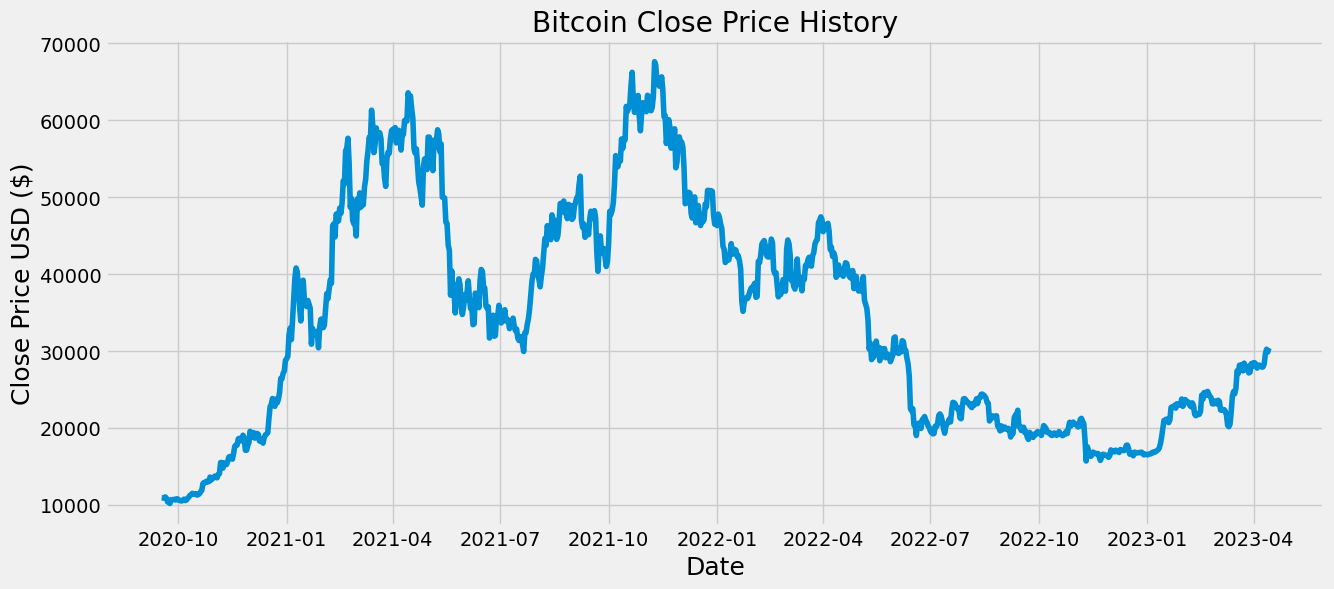

In [6]:
plt.figure(figsize=(14,6))
plt.title('Bitcoin Close Price History')
plt.plot(bitcoin_data_df['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [7]:
# Create a features function
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(bitcoin_data_df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
# Define the window size - number of time steps (historical data points) to be used for predicting the next time step
window_size = 30

# Set the index of the feature and target columns
feature_column = 1
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(bitcoin_data_df, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[10952.24996911 10937.99639696 10927.15031029 11083.9983612
  10923.32666818 10439.52248879 10527.58784674 10223.78410639
  10726.53008332 10681.99384811 10743.19287976 10765.30052166
  10672.02854426 10837.51658651 10770.88134747 10627.97606396
  10572.67484301 10546.65625538 10670.70081134 10784.94940309
  10605.95779131 10668.0110108  10888.66654684 11063.25238626
  11286.54194204 11377.81487676 11543.18376077 11426.10554422
  11435.57243758 11495.58499573]
 [10937.99639696 10927.15031029 11083.9983612  10923.32666818
  10439.52248879 10527.58784674 10223.78410639 10726.53008332
  10681.99384811 10743.19287976 10765.30052166 10672.02854426
  10837.51658651 10770.88134747 10627.97606396 10572.67484301
  10546.65625538 10670.70081134 10784.94940309 10605.95779131
  10668.0110108  10888.66654684 11063.25238626 11286.54194204
  11377.81487676 11543.18376077 11426.10554422 11435.57243758
  11495.58499573 11319.09778568]
 [10927.15031029 11083.9983612  10923.32666818 104

In [9]:
# Splitting the data into training and testing sets
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(637, 30) (637, 1) (273, 30) (273, 1)


In [10]:
# Create a MinMaxScaler object and fit 
scaler = MinMaxScaler()
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.01269254]
  [0.01244419]
  [0.01225521]
  [0.01498808]
  [0.01218859]
  [0.00375895]
  [0.00529337]
  [0.        ]
  [0.00315179]
  [0.00237142]
  [0.00344376]
  [0.00383114]
  [0.0021968 ]
  [0.00509652]
  [0.00392892]
  [0.0014249 ]
  [0.0004559 ]
  [0.        ]
  [0.00113562]
  [0.00313959]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.00104297]
  [0.00398036]
  [0.00190074]
  [0.0020689 ]
  [0.00313488]]

 [[0.01244419]
  [0.01225521]
  [0.01498808]
  [0.01218859]
  [0.00375895]
  [0.00529337]
  [0.        ]
  [0.00875967]
  [0.00237142]
  [0.00344376]
  [0.00383114]
  [0.0021968 ]
  [0.00509652]
  [0.00392892]
  [0.0014249 ]
  [0.0004559 ]
  [0.        ]
  [0.00217354]
  [0.00313959]
  [0.        ]
  [0.00108844]
  [0.00387462]
  [0.00307758]
  [0.00394827]
  [0.00162031]
  [0.00398036]
  [0.00190074]
  [0.0020689 ]
  [0.00313488]
  [0.        ]]

 [[0.01225521]
  [0.01498808]
  [0.01218859]
  [0.00375895]
  [0.00529337

In [11]:
# Build the LSTM model.
model = Sequential()

# Initial model setup
# number of nn units and include a 20% dropout_fraction to prevent overfitting. 
number_units = 40
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2 - LSTM layer
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3 - LSTM layer
model.add(LSTM(units=number_units, return_sequences=False))
model.add(Dropout(dropout_fraction))

# Layer 3 - Dense layer
model.add(Dense(units=20))

# Output layer
model.add(Dense(1))

In [12]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 40)            6720      
                                                                 
 dropout (Dropout)           (None, 30, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 40)            12960     
                                                                 
 dropout_1 (Dropout)         (None, 30, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 20)                8

In [13]:
# Train the model
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=90, verbose=1)

Epoch 1/50
8/8 [==============================] - 3s 21ms/step - loss: 0.1604
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0315
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0379
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0205
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0156
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0177
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0136
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0114
Epoch 9/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0120
Epoch 10/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0109
Epoch 11/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0114
Epoch 12/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0115
Epoch 13/50
8/8 [==============================] - 0s 20ms/st

In [14]:
# Evaluate the model
evaluate_num = model.evaluate(X_test, y_test, verbose=0)

# Print the evaluation score (MSE)
print("Model evaluation score (MSE):", round(evaluate_num, 6))


Model evaluation score (MSE): 0.000733


In [15]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

9/9 [==============================] - 1s 5ms/step


In [16]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [17]:
# Create a DataFrame of Real and Predicted values
bitcoin_predections_df = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = bitcoin_data_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
bitcoin_predections_df.head()

,Actual,Predicted
Date,,
2022-07-16,20794.811981,21455.855469
2022-07-17,21193.083343,21438.365234
2022-07-18,20824.362752,21433.343750
2022-07-19,22395.365383,21441.230469
2022-07-20,23366.907698,21500.890625


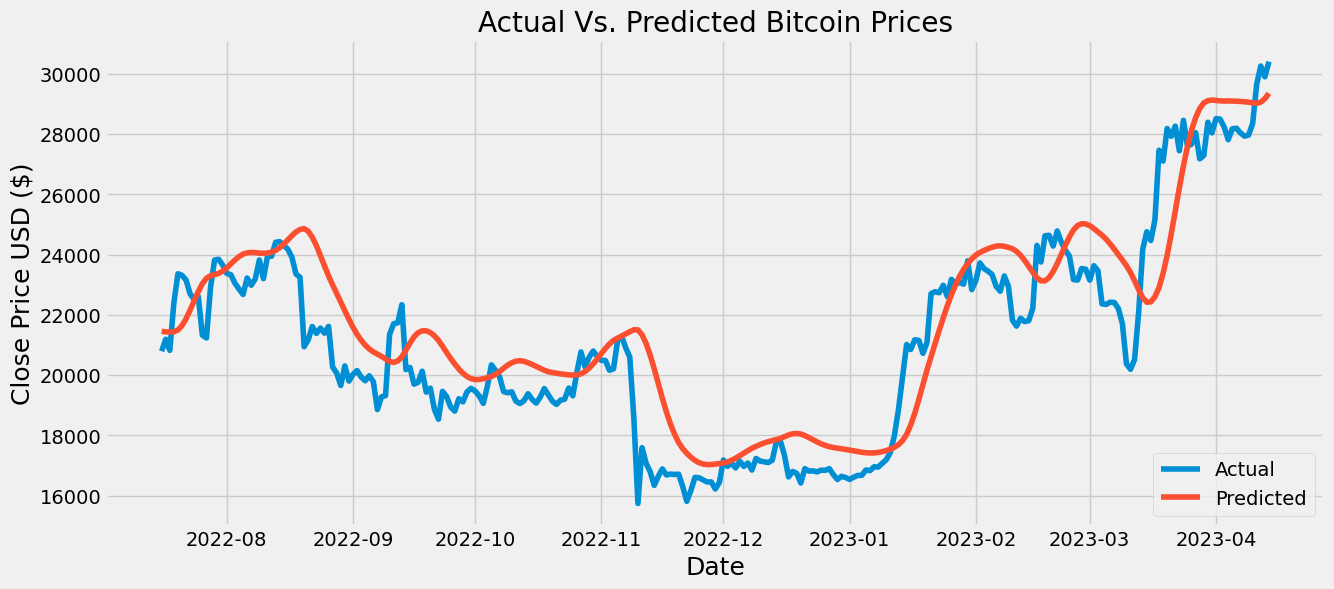

In [18]:
# Plot the real vs predicted prices as a line chart
# bitcoin_df.plot(title="Actual Vs. Predicted Bitcoin Prices")

plt.figure(figsize=(14,6))
plt.title('Actual Vs. Predicted Bitcoin Prices')
plt.plot(bitcoin_predections_df)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

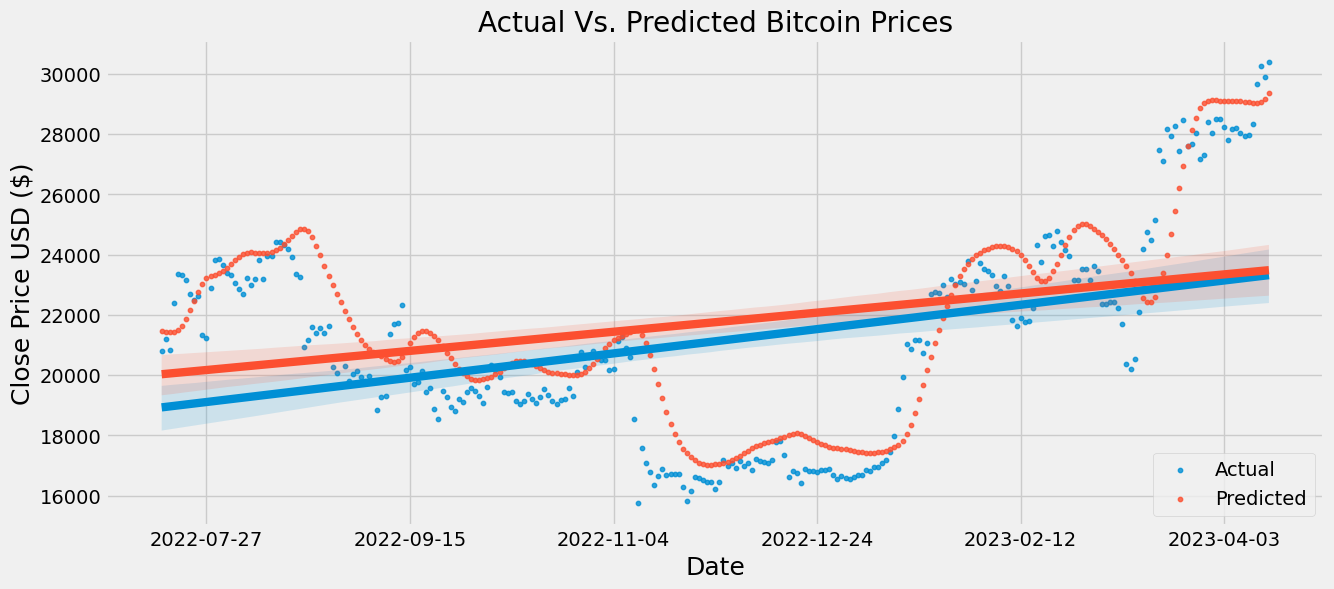

In [19]:
plt.figure(figsize=(14, 6))
plt.title('Actual Vs. Predicted Bitcoin Prices')

# Convert the Timestamp to a numerical value (number of days since a specific date)
x_values = mdates.date2num(bitcoin_predections_df.index.to_pydatetime())

# Use seaborn regplot to create a scatter plot with a regression line
sns.regplot(x=x_values, y=bitcoin_predections_df['Actual'], scatter_kws={'s': 10}, label='Actual')
sns.regplot(x=x_values, y=bitcoin_predections_df['Predicted'], scatter_kws={'s': 10}, label='Predicted')

# Format the x-axis to display dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='lower right')
plt.show()


In [20]:
def predict_future_prices(model, scaler, window_size, data, days):
    future_predictions = []
    input_data = data[-window_size:].copy()
    
    for i in range(days):
        # Scale the input data
        input_data_reshaped = input_data.reshape(-1, 1)
        scaled_input_data = scaler.transform(input_data_reshaped)
        
        # Reshape the input data to match the input shape of the model
        reshaped_input_data = scaled_input_data.reshape((1, window_size, 1))
        
        # Predict the price for the next day using the model
        predicted_price = model.predict(reshaped_input_data)
        
        # Inverse transform the predicted price
        unscaled_predicted_price = scaler.inverse_transform(predicted_price)
        
        # Append the price to the future_predictions list
        future_predictions.append(unscaled_predicted_price[0][0])
        
        # Add the predicted price to the end of input data and remove the first data point
        input_data = np.append(input_data[1:], unscaled_predicted_price)
    
    return future_predictions

In [21]:
# Predict Bitcoin prices for the next 10 days
days_to_predict = 10
last_window_data = bitcoin_data_df['Price'][-window_size:].values.reshape(-1, 1)
future_bitcoin_prices = predict_future_prices(model, scaler, window_size, last_window_data, days_to_predict)

# Find the last date in the dataset pulled from Crypto_Data table
last_date = bitcoin_data_df.index[-1]

# Generate fiture date range
future_dates = [last_date + timedelta(days=i+1) for i in range(days_to_predict)]

# Create a dictionary with dates and predicted prices
date_price_mapping = dict(zip(future_dates, future_bitcoin_prices))

# Create a DataFrame
future_bitcoin_prices_df = pd.DataFrame(list(date_price_mapping.items()), columns=['Date', 'Predicted'])

future_bitcoin_prices_df


1/1 [==============================] - 0s 14ms/step


,Date,Predicted
0,2023-04-15,29449.605469
1,2023-04-16,29701.308594
2,2023-04-17,29941.351562
3,2023-04-18,30157.806641
4,2023-04-19,30352.736328
5,2023-04-20,30527.886719
6,2023-04-21,30689.748047
7,2023-04-22,30842.402344
8,2023-04-23,30991.076172
9,2023-04-24,31136.230469


In [22]:
# Create a connection to the SQLite database
conn = create_connection(database)

if conn is not None:
    table_name = 'Bitcoin_Predictions'
        
    # Insert the DataFrame into the table
    future_bitcoin_prices_df.to_sql(table_name, conn, if_exists='replace', index=False)

else:
    print("Error! Cannot create the database connection.")

# Commit the changes and close the connection
conn.commit()
conn.close()

In [23]:
future_bitcoin_prices_df.set_index('Date', inplace=True)
future_bitcoin_prices_df

,Predicted
Date,
2023-04-15,29449.605469
2023-04-16,29701.308594
2023-04-17,29941.351562
2023-04-18,30157.806641
2023-04-19,30352.736328
2023-04-20,30527.886719
2023-04-21,30689.748047
2023-04-22,30842.402344
2023-04-23,30991.076172


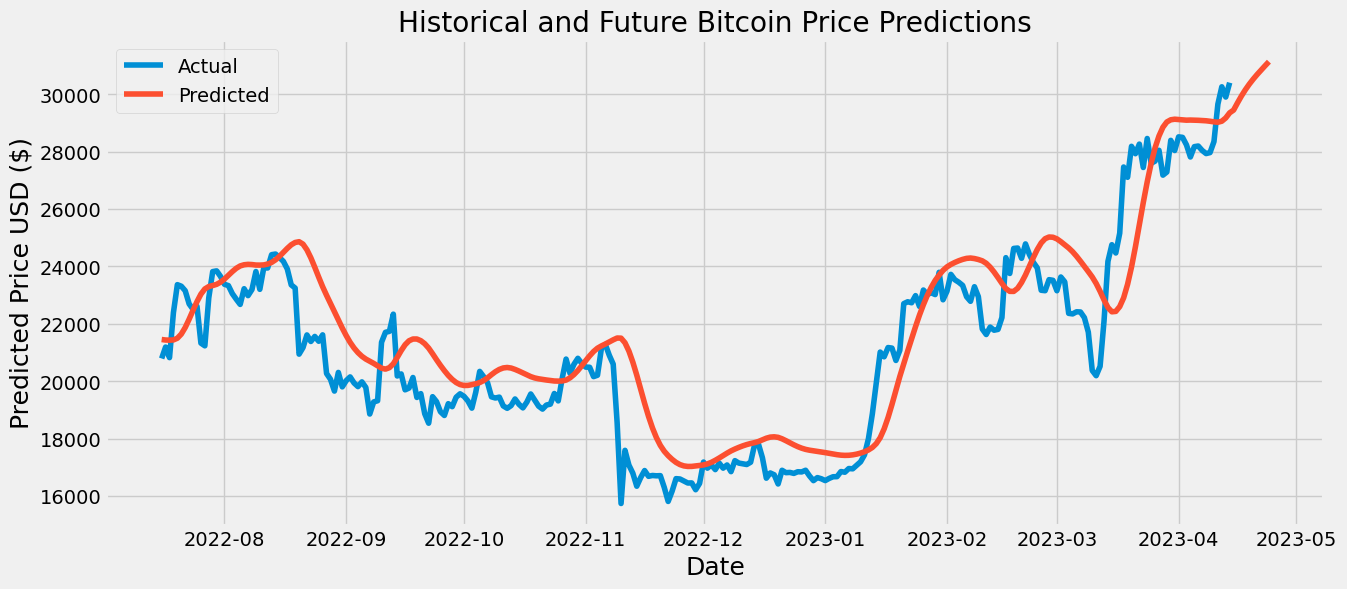

In [24]:
# Concatenate the two DataFrames
combined_df = pd.concat([bitcoin_predections_df, future_bitcoin_prices_df])

# Plot the combined data
plt.figure(figsize=(14, 6))
plt.title('Historical and Future Bitcoin Price Predictions')
plt.plot(combined_df)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Predicted Price USD ($)', fontsize=18)
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.show()